In [1]:
import tensorflow as tf
import keras
from tensorflow import keras
import kagglehub


from tensorflow.keras import utils
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

import os
import cv2
import numpy as np
from imgaug import augmenters as iaa

from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

In [2]:
path = kagglehub.dataset_download("lexset/synthetic-asl-alphabet")
train_images = os.path.join(path, 'Train_Alphabet')

# Augmentation Sequence
augmentation = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),  # Rotate images within [-10, 10] degrees
    iaa.AddToBrightness((-2, 2)),  # Adjust brightness
    iaa.AdditiveGaussianNoise(scale=(0, 0.00001 * 255)) # Add Gaussian noise
])
# Function to convert BGR to RGB for display
def convert_bgr_to_rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Data loading and augmentation
def get_data_with_augmentation(data_dir):
    images = []
    labels = []

    dir_list = os.listdir(data_dir)
    for i, label in enumerate(dir_list):
        print("Obtaining and augmenting images of", label, "...")
        for image in os.listdir(os.path.join(data_dir, label)):
            img_path = os.path.join(data_dir, label, image)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (32, 32))
            
            # Append the original image
            images.append(img)
            labels.append(i)

            # Apply augmentations
            img_augmented = augmentation(images=[img] * 2)  
            images.extend(img_augmented)
            labels.extend([i] * len(img_augmented))

    return np.array(images), np.array(labels)

# Loading data with augmentation
X, y = get_data_with_augmentation(train_images)

print("Dataset Size (including originals and augmentations):", len(X))


100%|██████████| 6.58G/6.58G [03:32<00:00, 33.3MB/s]

Extracting files...


Obtaining and augmenting images of R ...
Obtaining and augmenting images of U ...
Obtaining and augmenting images of I ...
Obtaining and augmenting images of N ...
Obtaining and augmenting images of G ...
Obtaining and augmenting images of Z ...
Obtaining and augmenting images of T ...
Obtaining and augmenting images of S ...
Obtaining and augmenting images of A ...
Obtaining and augmenting images of F ...
Obtaining and augmenting images of O ...
Obtaining and augmenting images of H ...
Obtaining and augmenting images of Blank ...
Obtaining and augmenting images of M ...
Obtaining and augmenting images of J ...
Obtaining and augmenting images of C ...
Obtaining and augmenting images of D ...
Obtaining and augmenting images of V ...
Obtaining and augmenting images of Q ...
Obtaining and augmenting images of X ...
Obtaining and augmenting images of E ...
Obtaining and augmenting images of B ...
Obtaining and augmenting images of K ...
Obtaining and augmenting images of L ...
Obtaining an

In [3]:
# Split into Training and Test
import sklearn
from sklearn.model_selection import train_test_split

labels = [
    'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 
    'Blank', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 
    'Y', 'P', 'W'
]

X = np.array(X)
y = np.array(y)

# Normalizing
X_normalized = X.astype('float32') / 255.0

# Training and Test
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Shapes
print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")


# Encoding
y_train_encoded = to_categorical(y_train, num_classes=len(labels))
y_test_encoded = to_categorical(y_test, num_classes=len(labels))


Training data shape: (58320, 32, 32, 3), Test data shape: (14580, 32, 32, 3)
Training labels shape: (58320,), Test labels shape: (14580,)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
classes = 27
batch = 96
epochs = 8
learning_rate = 0.001

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

from tensorflow.keras.regularizers import l2

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(classes, activation='softmax'))

adam = Adam(learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=2,              
    restore_best_weights=True 
)

history = model.fit(X_train, y_train_encoded, batch_size=batch, epochs=epochs, validation_split=0.2, shuffle = True, verbose=1,
    callbacks=[early_stopping])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/8
486/486 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.4291 - loss: 7.6209 - val_accuracy: 0.2862 - val_loss: 3.2306
Epoch 2/8
486/486 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8580 - loss: 1.0222 - val_accuracy: 0.9096 - val_loss: 0.8045
Epoch 3/8
486/486 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.8998 - loss: 0.8185 - val_accuracy: 0.9257 - val_loss: 0.7302
Epoch 4/8
486/486 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9161 - loss: 0.7365 - val_accuracy: 0.9306 - val_loss: 0.7423
Epoch 5/8
486/486 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9259 - loss: 0.7031 - val_accuracy: 0.9219 - val_loss: 0.7157
Epoch 6/8
486/486 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9335 - loss: 0.6401 - val_accuracy: 0.9408 - val_loss: 0.6492
Epoch 7/8
486/486 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.9429 - loss: 0.5986 - val_accuracy: 0.9518 - val_loss: 0.5641
Epoch 8/8
486/486 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9459 - loss: 0.5707 - val_accu

In [6]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9607 - loss: 0.5141
Test Loss: 0.5126, Test Accuracy: 0.9617


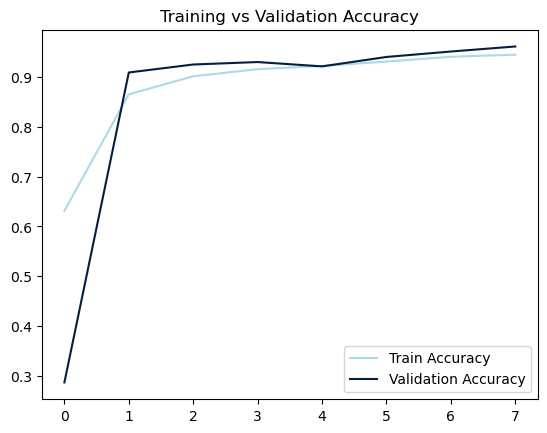

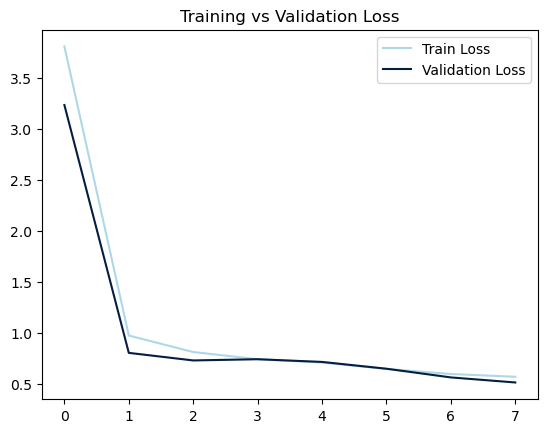

In [7]:
# Training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#ADD8E6')  # Training color
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#041E42')  # Validation color
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

# Training and validation loss
plt.plot(history.history['loss'], label='Train Loss', color='#ADD8E6')  # Training color
plt.plot(history.history['val_loss'], label='Validation Loss', color='#041E42')  # Validation color
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


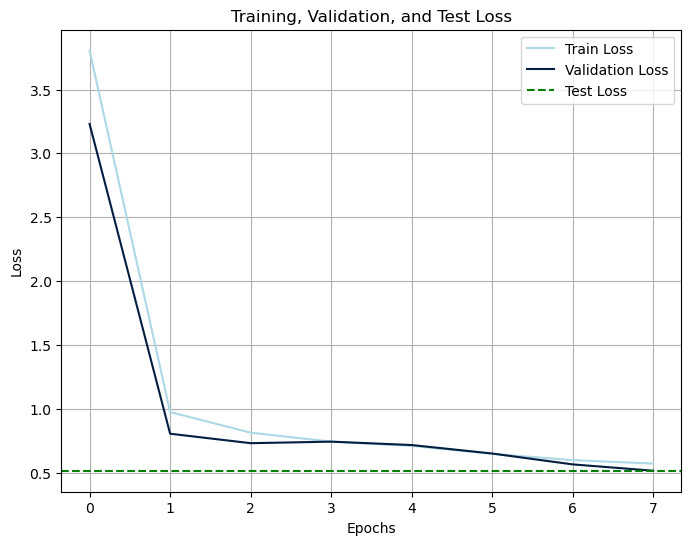

In [10]:
# Training, validation, and test loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss', color='#ADD8E6')  # Training color
plt.plot(history.history['val_loss'], label='Validation Loss', color='#041E42')  # Validation color
plt.axhline(test_loss, color='green', linestyle='--', label='Test Loss')  # Test loss as a horizontal line
plt.legend()
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [8]:
model.save('labeled.h5')

In [9]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

img_path = '/Users/hannahkim/Downloads/archive-2/asl_alphabet_test/asl_alphabet_test/B_test.jpg'
img = cv2.imread(img_path)

img_resized = cv2.resize(img, (32, 32))

img_rgb = convert_bgr_to_rgb(img_resized)

img_normalized = img_rgb.astype('float32') / 255.0

img_batch = np.expand_dims(img_normalized, axis=0)

y_pred = model.predict(img_batch)

y_pred_class = np.argmax(y_pred, axis=1)[0]

labels = [
    'R', 'U', 'I', 'N', 'G', 'Z', 'T', 'S', 'A', 'F', 'O', 'H', 
    'Blank', 'M', 'J', 'C', 'D', 'V', 'Q', 'X', 'E', 'B', 'K', 'L', 
    'Y', 'P', 'W'
]

predicted_label = labels[y_pred_class]

print(f"The predicted class for the image is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The predicted class for the image is: P
